In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import copy
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm

In [3]:
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from nuq import NuqClassifier

matplotlib.rcParams.update({"font.size": 12})


def plot_data(X, y, title=None):
    plt.close()
    plt.figure()
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.tight_layout()
    plt.show()


def make_data(total_size=5000, centers=np.array([[-4.0, -4.0], [0.0, 4.0]])):
    X, y = make_blobs(n_samples=total_size, n_features=2, centers=centers)
    return X, y

In [4]:
import ray

ray.init()
# ray.init(num_cpus=4)

2021-10-20 09:22:55,403	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.1.16.13',
 'raylet_ip_address': '10.1.16.13',
 'redis_address': '10.1.16.13:30007',
 'object_store_address': '/tmp/ray/session_2021-10-20_09-22-53_583635_3339760/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-20_09-22-53_583635_3339760/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2021-10-20_09-22-53_583635_3339760',
 'metrics_export_port': 59611,
 'node_id': '0ca02784a81b8bd543c04e7fdaed8b6dec6110b2468498bcb7fbb3cf'}

In [5]:
import hnswlib

# Number of points
N_base = 1000
N_query = 10
# Dimensonality
d = 50

X_base = np.random.uniform(size=(N_base, d))
X = np.random.uniform(size=(N_query, d))

In [6]:
# Number of points
N = 50000
# Number of classes
k = 3
# Dimensonality
d = 50
strategy = "isj"

X = np.random.uniform(size=(N, d))
y = np.random.choice(np.arange(k), N)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"{X_train.shape = }, {X_val.shape = }")

nuq = NuqClassifier(n_neighbors=20, strategy=strategy.lower(), tune_bandwidth=False)
nuq.fit(X_train, y_train)

X_train.shape = (40000, 50), X_val.shape = (10000, 50)


NuqClassifier(tune_bandwidth=False)

In [7]:
# %%timeit
# pred = nuq.predict_log_proba(X_val, return_uncertainty=False, batch_size=1000)

`4.04 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

vs

`4.04 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

In [ ]:
## Make a dataset
X, y = make_data(
    total_size=500,  # total_size=10_000,
    centers=np.array([[3.0, 0.0], [3.0, 2.0], [0.0, 10]]),
)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5

# h_x, h_y = 0.05, 0.05
h_x, h_y = [0.1] * 2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
X_test = np.c_[xx.ravel(), yy.ravel()]
print(f"{X_test.shape = }")

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), dpi=200, sharey=True)
ax[0].set_title("Raw data")
ax[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# strategy options: 'isj', 'silverman', 'scott', 'classification'
for i, strategy in enumerate(["ISJ", "Classification"]):
    nuq = NuqClassifier(
        strategy=strategy.lower(),
        tune_bandwidth=False,
        kernel_type="RBF",
        n_neighbors=20,
        log_pN=0.0,
    )
    nuq.fit(X=X_train, y=y_train)

    ax[1].set_title("Classification")
    probs, uncertainty = nuq.predict_proba(X_test, return_uncertainty=True)
    ax[1].contourf(xx, yy, np.max(probs, axis=-1).reshape(*xx.shape))

    ax[i + 2].set_title(f"Uncertainty ({strategy})")
    ax[i + 2].contourf(xx, yy, uncertainty.reshape(*xx.shape))

plt.tight_layout()
plt.show()

In [ ]:
fig.savefig("student_nuq.pdf")

In [ ]:
## Make a dataset
X, y = make_data(
    total_size=500,  # total_size=10_000,
    centers=np.array([[3.0, 0.0], [4.0, 3.0], [0.0, 10]]),
)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True)
ax.set_title("Raw data")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

plt.show()

In [5]:
from sklearn.model_selection import GridSearchCV

n_points = 10
cv = 3
verbose = 0

Ns = (100 * np.logspace(0, 6, num=8, base=2)).astype(np.int64)
print(f"{Ns = }")

results = []
for N in tqdm(Ns):
    X, y = make_data(
        total_size=N,
        centers=np.array([[3.0, 0.0], [4.0, 3.0], [0.0, 10]]),
    )

    nuq = NuqClassifier(
        strategy="isj",
        tune_bandwidth=False,
        kernel_type="RBF",
        n_neighbors=20,
        log_pN=0.0,
    )
    nuq.fit(X=X, y=y)

    _, dists = ray.get(nuq.index_.knn_query.remote(nuq.X_ref_, return_dist=True))
    dists_mean = dists.mean(axis=0)
    left, right = dists_mean[1], dists_mean[-1]

    grid = np.linspace(left, right, n_points)

    gs = GridSearchCV(
        nuq,
        param_grid={"bandwidth": grid},
        scoring="accuracy",
        cv=cv,
        n_jobs=None,
        verbose=verbose,
    )
    gs.fit(X, y)

    results.append(
        {"N": N, "bandwidth": gs.best_params_["bandwidth"], "score": gs.best_score_}
    )

results_df = pd.DataFrame(results)

Ns = array([ 100,  181,  328,  594, 1076, 1950, 3533, 6400])


  0%|          | 0/8 [00:00<?, ?it/s]

2021-10-20 03:16:40,360	WARNING worker.py:1215 -- The actor or task with ID 6f11fc36ae79b72510017be123c82e40b441ebf93d6a8211 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU: 1.000000}
Available resources on this node: {7.000000/8.000000 CPU, 1.140102 GiB/1.140102 GiB memory, 0.570051 GiB/0.570051 GiB object_store_memory, 1.000000/1.000000 node:192.168.1.29}
In total there are 1 pending tasks and 0 pending actors on this node.


In [6]:
results_df

,N,bandwidth,score
0,100,1.338210,0.960190
1,181,0.655068,0.961293
2,328,0.404484,0.957326
3,594,0.589011,0.962963
4,1076,0.374898,0.961892
5,1950,0.189822,0.953846
6,3533,0.130281,0.946503
7,6400,0.076928,0.949375


In [8]:
from functools import partial

def get_kernel(old_h, old_N, new_N, dim):
    return old_h * np.exp((np.log(old_N) - np.log(new_N)) / (dim + 4))

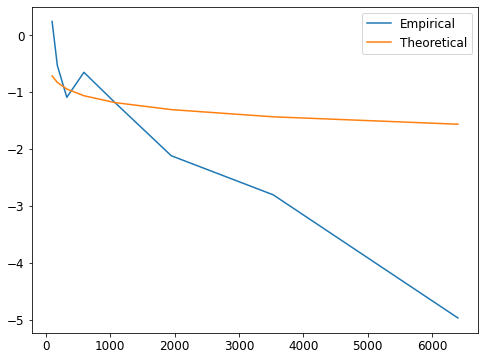

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

base_idx = 4
f = partial(
    get_kernel,
    results_df["bandwidth"].values[base_idx],
    results_df["N"].values[base_idx],
    dim=2,
)

eps = 0.07
ax.plot(results_df["N"], np.log(results_df["bandwidth"] - eps), label="Empirical")
ax.plot(
    results_df["N"],
    np.log(np.array([f(x) for x in results_df["N"]]) - eps),
    label="Theoretical",
)
ax.legend()

plt.show()

In [13]:
N = 1000

X, y = make_data(
    total_size=N,
    centers=np.array([[3.0, 0.0], [4.0, 3.0], [0.0, 10]]),
)

In [14]:
nuq = NuqClassifier(
    tune_bandwidth="classification:n_folds=5;verbose=1",
    kernel_type="RBF",
)
nuq.fit(X=X, y=y)
nuq.score(X=X, y=y)

Tuning bandwidth:   0%|          | 0/3 [00:00<?, ?it/s]

  [CLASSIFICATION:N_FOLDS=5;VERBOSE=1] bandwidth = 0.48232296109199524 (score = 0.9499999999999998)


0.959

In [15]:
nuq.predict(X)

array([2, 2, 1, 0, 2, 2, 1, 2, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0, 1, 2, 2,
       0, 0, 1, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2,
       1, 2, 0, 0, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 2, 1, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 2, 2, 2, 2, 1,
       0, 1, 1, 2, 0, 0, 0, 2, 1, 1, 2, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1,
       2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 1, 1, 0, 0, 1,
       2, 0, 0, 2, 1, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 1,
       2, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 0, 0, 2, 1, 0, 1,
       2, 2, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 0, 1, 2,
       1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 2,
       1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 1, 2, 0, 0, 2,
       1, 0, 2, 1, 0, 1, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2,
       1, 0, 1, 1, 2, 1, 0, 0, 2, 0, 1, 1, 2, 0, 1,